# Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from NCA.NCA import *
import NCA.utils as utils 
from IPython.display import Image, HTML, clear_output
import logging
import os
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# Initial Setup 

In [2]:
DEVICE = "cuda:0" #<-- Device to use, CUA recommended 
HEIGHT = 60
WIDTH = 60
CHANNELS = 16 #<--- NCA feature channels
BATCH_SIZE = 12  
PADDING = 0
GENE_COUNT = 8 #<-- Number of gene channels to use for "private" information 
POOL_SIZE = 2666 #<--- NCA training pool size, lower values train faster but are less stable
TRAINING_ITERS = 14000  #<-- Number of trainign iterations 
HIDDEN_N = 124

# Loading and Setting up Images

In [3]:
paths = [ "../Images/lizard.png"] #<-- Final morphology(ies), can be more than one 
images = []
images_to_display = []
for path in paths:
    image, image_to_display = utils.get_image(path, HEIGHT, WIDTH, padding=PADDING)
    images.append(image)
    images_to_display.append(image_to_display)
genes = [[1]]
HEIGHT = HEIGHT + 2*PADDING
WIDTH = WIDTH + 2*PADDING
assert len(paths) == len(genes), 'Genes and images should have the same length '

# Displaying Images and Making Training Pools

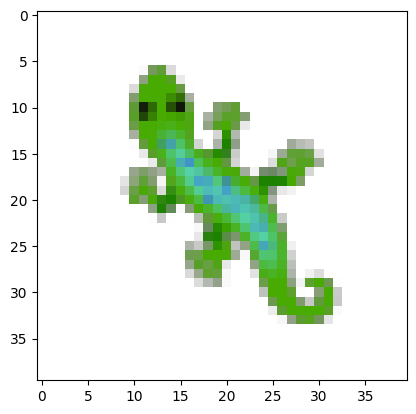

In [4]:
for i,image in enumerate(images_to_display):
    plt.figure(3+i)
    plt.imshow(image)
pools = []
for gene in genes:
    pools.append(utils.make_gene_pool(gene, pool_size= 1000, height=HEIGHT, width=WIDTH, channels=CHANNELS, gene_size=8))
seeds = []
for pool in pools:
    seeds.append(pool[0].clone())



# Creating Batch Partitions for Every Image 

In [5]:
partitions = len(paths)
if partitions == 1:
    part = [BATCH_SIZE]
div = BATCH_SIZE//partitions
rem = BATCH_SIZE % partitions
part = [div + 1 if i < rem else div for i in range(partitions)]
print(part)


[12]


# Assigning Secondary Genes for Multi Image Gene Prop 

In [6]:
gene_2 = []
for idx,p in enumerate(part):
    gene = torch.zeros((1,HEIGHT,WIDTH), device=DEVICE)
    gene[:,HEIGHT//2,WIDTH//2] = idx
    gene_2.append(gene.tile(p, 1, 1, 1))
genes = torch.cat(gene_2, dim = 0)

# Filters for Loss Function

In [7]:
sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]], dtype=torch.float32, device="cuda:0")
lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]], dtype=torch.float32, device="cuda:0")
filters = torch.stack([sobel_x, sobel_x.T, lap])
folder = "GeneProp"

# Dirr Setup for Saving Models and Experimental Data 

In [8]:
path = "Trained_models/" + folder
if not os.path.exists(path):
    os.makedirs(path)
    print(f"Path: {path} created")
else: 
    print(f"Path: {path} already exists, all OK!")
    
path = "Saved_Data/" + folder
if not os.path.exists(path):
    os.makedirs(path)
    print(f"Path: {path} created")
else: 
    print(f"Path: {path} already exists, all OK!")

Path: Trained_models/GeneProp created
Path: Saved_Data/GeneProp created


# Setting Up NCA and Batched Target Image

In [9]:
bases = [images[i].tile(part[i],1,1,1) for i in range(len(part))]
base = torch.cat(bases, dim =0 )
loss_log = []
with torch.no_grad():
    ncaPre = GeneCA(CHANNELS,hidden_n=64, gene_size=GENE_COUNT)
    ncaPre.load_state_dict(torch.load("Trained_models/Gene/GeneCA_gene_size_8.pth"))
    ncaPre.to(DEVICE).eval()
nca = GenePropCA(CHANNELS,124, gene_size=GENE_COUNT)
nca = nca.to(DEVICE)
optim = torch.optim.AdamW(nca.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5000, gamma=0.3)
name = folder + "/" +type(nca).__name__ + "_gene_size_" +str(GENE_COUNT)

/tmp/ipykernel_8105/429281325.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ncaPre.load_state_dict(torch.load("Trained_models/Gene/GeneCA_gene_size_8.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'Trained_models/Gene/GeneCA_gene_size_8.pth'

# Training

In [ ]:
#TODO: Make it so that multi image gene props use the secondary genes
for i in range(TRAINING_ITERS + 1):
    loss = 0
    with torch.no_grad():
        idxs, x = utils.get_gene_pool(pools, part, seeds)

    itters = random.randrange(32,92)
    for _ in range( itters):
        x = ncaPre(x)
        x = nca(x)
    
    loss = (base - x[:, :4, :, :]).pow(2).sum() + 0.1 *(perchannel_conv(base, filters) - perchannel_conv(x[:, :4, :, :], filters) ).pow(2).sum() 
    with torch.no_grad():
        loss.backward()
        for p in nca.parameters():
            p.grad /= (p.grad.norm() + 1e-8)
        optim.step()
        x = x.detach()
        optim.zero_grad()
    
    loss_log.append(loss.log().item())
    with torch.no_grad():   
        pools = utils.udate_gene_pool(pools, x.clone().detach(), idxs, part)
    scheduler.step()

    if i % 100 == 0:
        print(f"Training itter {i}, loss = {loss.item()}")
        plt.clf()
        clear_output()
        plt.figure(1,figsize=(10, 4))
        plt.title('Loss history)')
        print(name)
        plt.plot(loss_log, '.', alpha=0.5, color = "b")
        utils.show_batch(x[2:10])
        plt.show(block=False)
        plt.pause(0.01)
    if i % 100 == 0:
        torch.save(nca.state_dict(), "Trained_models/" + name + ".pth")

np_logg = np.asarray(loss_log)
np.save("Saved_Data/" + name + "_data", np_logg)
